# Linear Elasticity

*Authors: Laura De Lorenzis (ETH Zürich) and Corrado Maurini (corrado.maurini@sorbonne-universite.fr)*

This notebook serves as a tutorial to solve a problem of linear elasticity use dolfin-x

You can tutorial and resources for dolfin-x at the following links

- https://docs.fenicsproject.org/dolfinx/master/python/
- https://github.com/FEniCS/dolfinx/
- https://jorgensd.github.io/dolfinx-tutorial/, see https://jorgensd.github.io/dolfinx-tutorial/chapter2/linearelasticity.html for linear elasticity

We consider an elastic slab $\Omega$ with a straigth crack $\Gamma$ submitted to a mode-I loading by an applied traction force $f$, see figure. 

Using the symmetry, we will consider only half of the domain in the computations.

![title](./domain.png)

We solve the problem of linear elasticity with the finite element method, implemented with the help of fenics-x.

Fenics-x is advanced library that aallows for efficient parallel computation. For the sake of simplicity, we assume here to work on a single processor and not use MPI-related commands. 

In [3]:
# This enables a working tab completion 
%config Completer.use_jedi = False
%config IPCompleter.greedy = True
import sys
sys.path.append('../')
# Import required libraries
import matplotlib.pyplot as plt
import numpy as np

import dolfinx
import ufl

from mpi4py import MPI
from petsc4py import PETSc

from utils import project
from meshes import generate_mesh_with_crack

plt.rcParams["figure.figsize"] = (40,6)

ModuleNotFoundError: No module named 'dolfinx'

Let us first generate a mesh using gmsh (http://gmsh.info/). 

The function to generate the mesh is reported in the external file `meshes.py`. 
The mesh is refined around the crack tip.

In [2]:
Lx = 1.
Ly = .5
Lcrack = 0.3
lc =.2
dist_min = .1
dist_max = .3
mesh = generate_mesh_with_crack(Lcrack=Lcrack,
                 Lx=Lx,
                 Ly=Ly,
                 lc=lc, # caracteristic length of the mesh
                 refinement_ratio=20, # how much it is refined at the tip zone
                 dist_min=dist_min, # radius of tip zone
                 dist_max=dist_max # radius of the transition zone 
                 )


  return array(obj, copy=False)



To plot the mesh we use `pyvista` see:
- https://jorgensd.github.io/dolfinx-tutorial/chapter3/component_bc.html
- https://docs.fenicsproject.org/dolfinx/master/python/demos/pyvista/demo_pyvista.py.html

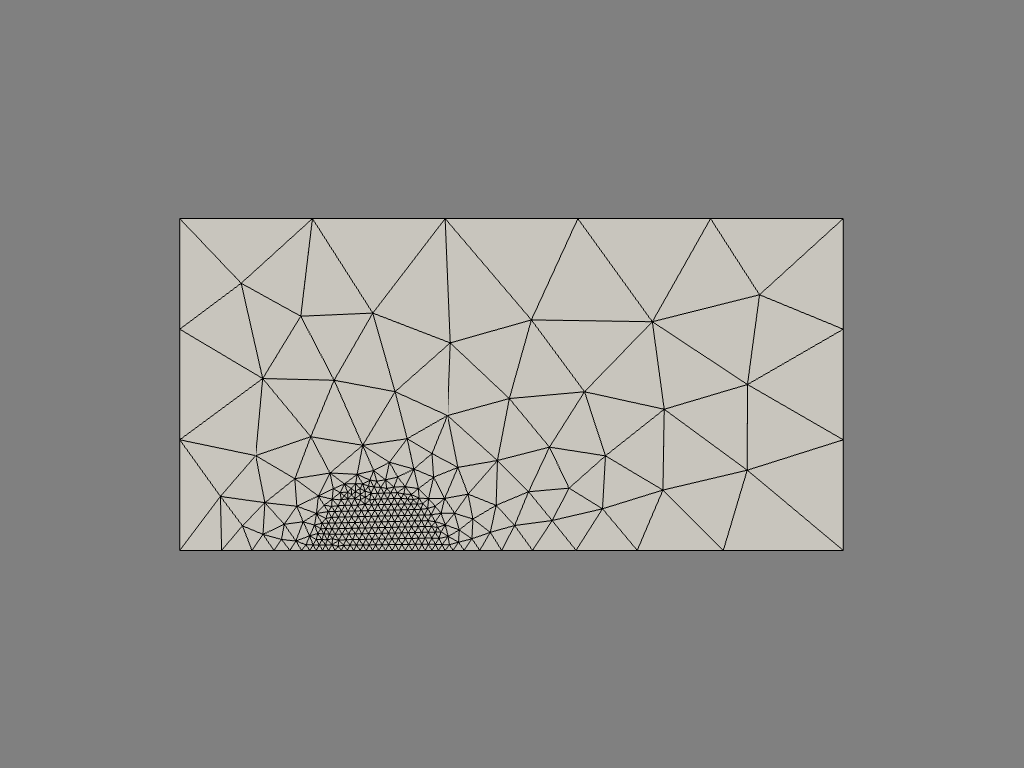

In [5]:
import pyvista

import dolfinx.plot

# If environment variable PYVISTA_OFF_SCREEN is set to true save a png
# otherwise create interactive plot
if pyvista.OFF_SCREEN:
    from pyvista.utilities.xvfb import start_xvfb
    start_xvfb(wait=0.1)

# Set some global options for all plots
transparent = False
figsize = 800
pyvista.rcParams["background"] = [0.5, 0.5, 0.5]


topology, cell_types = dolfinx.plot.create_vtk_topology(mesh, mesh.topology.dim)

grid = pyvista.UnstructuredGrid(topology, cell_types, mesh.geometry.x)

from pyvista.utilities.xvfb import start_xvfb
start_xvfb(wait=0.0)
plotter = pyvista.Plotter()
plotter.add_mesh(grid, show_edges=True, show_scalar_bar=True)
plotter.view_xy()
if not pyvista.OFF_SCREEN:
    plotter.show()

## Finite element function space

We use here linear Lagrange triangle elements

In [6]:
element = ufl.VectorElement('P',mesh.ufl_cell(),degree=1,dim=2)
V = dolfinx.FunctionSpace(mesh, element)

## Dirichlet boundary conditions

We define below the classes to impose the Dirichlet boundary conditions.

In our case we want to 
- block the vertical component $u_1$ of the displacement on the part of the bottom boundary without crack
- block the horizontal component $u_0$ on the right boundary

We first get the dofs we need to block through specific dolfinx functions.

The function `locate_dofs_geometrical` takes the dofs of the function space `V.sub(comp)` associated to the component `comp`. The syntax is not intuitive here. 

In [7]:
def bottom_no_crack(x):
    return np.logical_and(np.isclose(x[1], 0.0), 
                          x[0] > Lcrack)

def right(x):
    return np.isclose(x[0], Lx)

blocked_dofs_bottom = dolfinx.fem.locate_dofs_geometrical((V.sub(1), V.sub(1).collapse()), bottom_no_crack)
blocked_dofs_right = dolfinx.fem.locate_dofs_geometrical((V.sub(0), V.sub(0).collapse()), right)

The following lines define the BC's objects. We impose null displacement.

In [8]:
zero = dolfinx.Function(V.sub(0).collapse())
with zero.vector.localForm() as bc_local:
    bc_local.set(0.0)
    
bc0 = dolfinx.DirichletBC(zero, blocked_dofs_bottom, V.sub(1))
bc1 = dolfinx.DirichletBC(zero, blocked_dofs_right, V.sub(0))
bcs = [bc0,bc1]

## Define the bulk and surface mesures
The bulk (`dx`) and surface (`ds`) measures are used by `ufl`to write variational form with integral over the domain or the boundary. In this example the surface measure `ds` includes tags to specify Neumann bcs: `ds(1)` will mean the integral on the top boundary. 

In [9]:
dx = ufl.Measure("dx",domain=mesh)
top_facets = dolfinx.mesh.locate_entities_boundary(mesh, 1, lambda x : np.isclose(x[1], Ly))
mt = dolfinx.mesh.MeshTags(mesh, 1, top_facets, 1)
ds = ufl.Measure("ds", subdomain_data=mt)

In python, you can get help on the different functions with the folling syntax:

In [10]:
help(dolfinx.mesh.MeshTags)

Help on function MeshTags in module dolfinx.mesh:

MeshTags(mesh, dim, indices, values)



## Define the variational problem 

We specify the problem to solve though the weak formulation written in the [ufl](https://fenics.readthedocs.io/projects/ufl/en/latest/) syntax by giving the bilinear $a(u,v)$ and linear forms $L(v)$ in 
the weak formulation: find the *trial function* $u$ such that for all *test function* $v$
$$a(u,v)=L(v)$$ with 

$$a(u,v)=\int_{\Omega\setminus\Gamma}\sigma(\varepsilon(u))\cdot \varepsilon(v)\,\mathrm{d}x, 
\quad L(v)=\int_\Omega b\cdot v \,\mathrm{d}x + \int_{\partial_N\Omega} f\cdot v \,\mathrm{d}s $$

In [11]:
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)

E = 1. 
nu = 0.3 
mu = E / (2.0 * (1.0 + nu))
lmbda = E * nu / ((1.0 + nu) * (1.0 - 2.0 * nu))
# this is for plane-stress
lmbda = 2*mu*lmbda/(lmbda+2*mu)

def eps(u):
    """Strain"""
    return ufl.sym(ufl.grad(u))

def sigma(eps):
    """Stress"""
    return 2.0 * mu * eps + lmbda * ufl.tr(eps) * ufl.Identity(2)

def a(u,v):
    """The bilinear form of the weak formulation"""
    return ufl.inner(sigma(eps(u)), eps(v)) * dx

def L(v): 
    """The linear form of the weak formulation"""
    # Volume force
    b = dolfinx.Constant(mesh,ufl.as_vector((0,0)))

    # Surface force on the top
    f = dolfinx.Constant(mesh,ufl.as_vector((0,0.1)))
    return ufl.dot(b, v) * dx + ufl.dot(f, v) * ds(1)

## Define the linear problem and solve
We solve the problem using a direct solver. The class `dolfinx.fem.LinearProblem` assemble the stiffness matrix and load vector, apply the boundary conditions, and solve the linear system.

In [12]:
problem = dolfinx.fem.LinearProblem(a(u,v), L(v), bcs=bcs, petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
uh = problem.solve()
uh.name = "displacement"

## Postprocessing

We can easily calculate the potential energy

In [13]:
energy = dolfinx.fem.assemble_scalar(0.5 * a(uh, uh) - L(uh))
print(f"The potential energy is {energy:2.3e}")

The potential energy is -3.972e-03


We can save the results to a file, that we can open with `paraview` (https://www.paraview.org/)

In [14]:
from pathlib import Path

Path("output").mkdir(parents=True, exist_ok=True)    
with dolfinx.io.XDMFFile(MPI.COMM_WORLD, "output/elasticity-demo.xdmf", "w") as file:
        file.write_mesh(uh.function_space.mesh)
        file.write_function(uh)

Let us plot the solution using `pyvista`, see
- https://jorgensd.github.io/dolfinx-tutorial/chapter3/component_bc.html
- https://docs.fenicsproject.org/dolfinx/master/python/demos/pyvista/demo_pyvista.py.html£

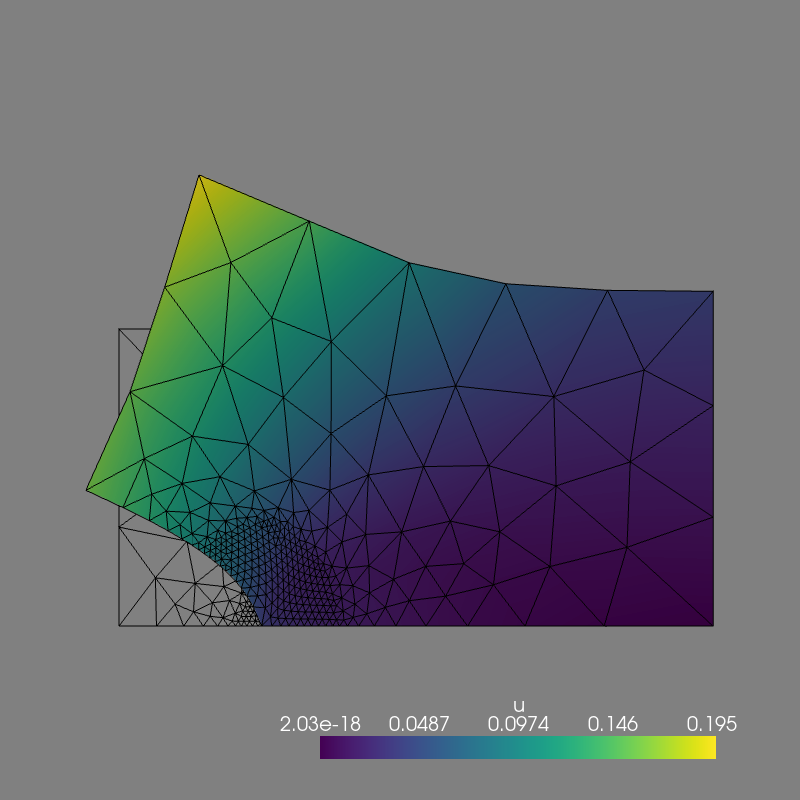

In [15]:
# Create plotter and pyvista grid
p = pyvista.Plotter(title="Deflection", window_size=[800, 800])
topology, cell_types = dolfinx.plot.create_vtk_topology(mesh, mesh.topology.dim)
grid = pyvista.UnstructuredGrid(topology, cell_types, mesh.geometry.x)

# Attach vector values to grid and warp grid by vector
vals_2D = uh.compute_point_values().real 
vals = np.zeros((vals_2D.shape[0], 3))
vals[:,:2] = vals_2D
grid["u"] = vals
actor_0 = p.add_mesh(grid, style="wireframe", color="k")
warped = grid.warp_by_vector("u", factor=1.5)
actor_1 = p.add_mesh(warped, show_edges=True)
p.view_xy()
if not pyvista.OFF_SCREEN:
   p.show()
fig_array = p.screenshot(f"output/displacement.png")